In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import env

from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

## Exercise
### Save this work in your anomaly-detection-exercises repository in a file named discrete_anomaly_detection.ipynb.

### Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [2]:
#For this exercise I used data generated by Codeup's first data science cohort, Ada. 
#The data comes from the webserver logs of the API that was used in the timeseries module. 
#Each row is one request to the server.

# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
# For the sake of this exercise I created some sythetic records and append them to our existing data frame.

new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [4]:
#convert timestamp & set as index
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [5]:
#Detecting anomalies in discrete variables
#check ip value count
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: ip, dtype: int64

In [6]:
#normalize the discrete variables
df.ip.value_counts(normalize=True)

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
24.26.242.9       0.001502
35.175.171.137    0.000143
52.87.230.102     0.000143
70.121.214.34     0.000143
52.90.165.200     0.000072
95.31.16.121      0.000072
95.31.18.119      0.000072
45.23.250.16      0.000072
52.91.30.150      0.000072
34.207.64.242     0.000072
3.88.129.158      0.000072
54.172.14.223     0.000072
3.92.201.136      0.000072
35.174.209.2      0.000072
54.145.52.184     0.000072
34.229.70.250     0.000072
97.105.15.120     0.000072
Name: ip, dtype: float64

In [7]:
#We can define a function that combines both these pieces of information:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [8]:
#lets check the ip df frequencies
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


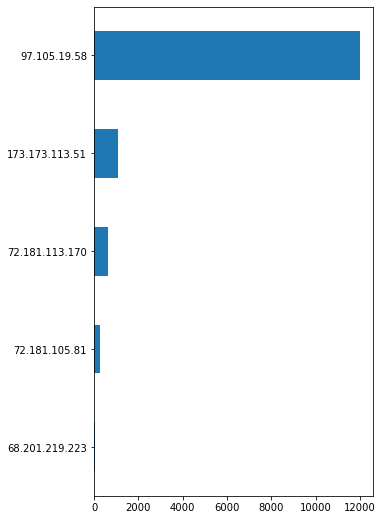

In [9]:
#now we can find how many unique ip addresses are there:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()

In [11]:
# Given a particular ip, what is probability of a certain status code
#same thing, diferent method, using groupby and normalizing value counts

status_code_ip = df.groupby('ip').status_code.value_counts(normalize=True).\
                rename('proba_status_code_ip').reset_index()
status_code_ip.head()

,ip,status_code,proba_status_code_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [12]:
#Which IP addresses give us multiple status codes?
status_code_ip [status_code_ip.proba_status_code_ip < 1]

,ip,status_code,proba_status_code_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [13]:
#Let's investigate the '72.181.113.170' address
df [df.ip == '72.181.113.170'].sort_values('status_code', 
                                           ascending=False)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 02:48:36,72.181.113.170,GET,/api/v1/sales?page=8,HTTP/1.1,499,0,python-requests/2.21.0,0.000000
2019-04-17 03:42:44,72.181.113.170,GET,/api/v1/sales?page=133,HTTP/1.1,499,0,python-requests/2.21.0,0.000000
2019-04-17 03:42:17,72.181.113.170,GET,/api/v1/sales?page=120,HTTP/1.1,200,510681,python-requests/2.21.0,0.487023
2019-04-17 03:42:01,72.181.113.170,GET,/api/v1/sales?page=113,HTTP/1.1,200,511094,python-requests/2.21.0,0.487417
2019-04-17 03:42:03,72.181.113.170,GET,/api/v1/sales?page=114,HTTP/1.1,200,511291,python-requests/2.21.0,0.487605
...,...,...,...,...,...,...,...,...
2019-04-17 03:28:07,72.181.113.170,GET,/api/v1/sales?page=100,HTTP/1.1,200,512674,python-requests/2.21.0,0.488924
2019-04-17 03:28:08,72.181.113.170,GET,/api/v1/sales?page=101,HTTP/1.1,200,510509,python-requests/2.21.0,0.486859
2019-04-17 03:28:11,72.181.113.170,GET,/api/v1/sales?page=102,HTTP/1.1,200,512612,python-requests/2.21.0,0.488865


In [14]:
#let's check the path value counts
df.request_path.value_counts()

/api/v1/sales?page=2               709
/api/v1/items                      464
/api/v1/items?page=2               291
/api/v1/items?page=3               219
/api/v1/stores                     162
                                  ... 
/api/v1                              1
/api/v1//api/v1/items/next_page      1
/api/v1//api/v1/items                1
/api/v1/items?page=0                 1
/api/V1/HiZach!                      1
Name: request_path, Length: 220, dtype: int64

In [15]:
#let's normalize the path value counts
df.request_path.value_counts(normalize=True)

/api/v1/sales?page=2               0.050723
/api/v1/items                      0.033195
/api/v1/items?page=2               0.020818
/api/v1/items?page=3               0.015667
/api/v1/stores                     0.011590
                                     ...   
/api/v1                            0.000072
/api/v1//api/v1/items/next_page    0.000072
/api/v1//api/v1/items              0.000072
/api/v1/items?page=0               0.000072
/api/V1/HiZach!                    0.000072
Name: request_path, Length: 220, dtype: float64

In [16]:
#lets print the upper column and their value counts
for col in df.columns:
    print(col.upper())
    print(df[col].value_counts())
    print('--------------------')

IP
97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: ip, dtype: int64
--------------------
REQUEST_METHOD
GET    13978
Name: request_method, dtype: int64
--------------------
REQUEST_PATH
/api/v1/sales?page=2               709
/api/v1/items                      464
/api/v1/items?page=2               291
/api/v1/items?page=3               219
/api/v1/stores                     162
                                  ... 
/api/v1                              1
/api/v1//api/v1/items/next_page      1
/api/v1//api/v1/

In [17]:
#lets check the value counts and their frequencies
ip_req = value_counts_and_frequencies(df.request_path)
ip_req

,count,proba
/api/v1/sales?page=2,709,0.050723
/api/v1/items,464,0.033195
/api/v1/items?page=2,291,0.020818
/api/v1/items?page=3,219,0.015667
/api/v1/stores,162,0.011590
...,...,...
/api/v1,1,0.000072
/api/v1//api/v1/items/next_page,1,0.000072
/api/v1//api/v1/items,1,0.000072
/api/v1/items?page=0,1,0.000072


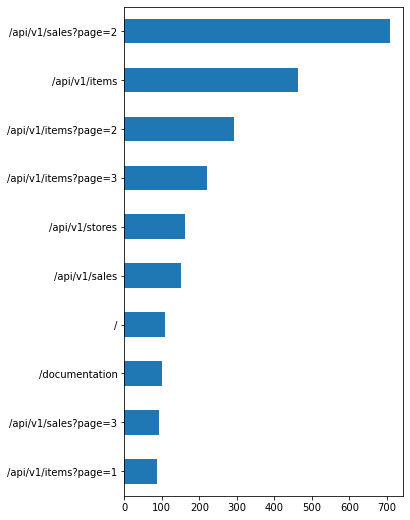

In [18]:
#now we can plot the requested frequencies
ip_req['count'].sort_values().tail(10).plot.barh(figsize=(5, 9))
plt.show()